<h2><center>Carbon output prediction in Africa using CO2 emissions data</h2></center>  


*About the problem*
> The ability to accurately monitor carbon emissions is a critical step in the fight against climate change. Precise carbon readings allow researchers and governments to understand the sources and patterns of carbon mass output. While Europe and North America have extensive systems in place to monitor carbon emissions on the ground, there are few available in Africa.

*Objective of this challenge*
> The objective of this challenge is to create machine learning or a deep learning model using open-source CO2 emissions data (from Sentinel-5P satellite observations) to predict carbon emissions. 

*Data*
> Approximately 800 locations were selected from 20 areas in South Africa, with a distribution around farm lands, cities and power plants. </br>
The train set contains 361 locations and the test contains 137 locations. The test set is from a different province to the train set, to ensure the model is generalisable to different regions.

These solutions will enable EY, governments, and other actors to estimate carbon emission levels across Africa, even in places where on-the-ground monitoring is not possible

## Table of contents:

1. [Installing and importing libraries](#Libraries)
2. [Loading data](#Data)
3. [Statistical summaries](#Statistics)
4. [Outliers](#Outliers)
5. [Geo Visualisation - EDA](#Geo)
5. [Missing values and duplicates](#Missing)
6. [Date features EDA](#Dates)
7. [Correlations - EDA](#Correlations)
9. [Timeseries visualization - EDA](#Timeseries)
10. [Feature engineering](#Engineering)
11. [Modelling](#Modelling)
12. [Making predictions of the test set and creating a submission file](#Predictions)

<a name="Libraries"></a>
## 1. Installing and importing libraries


In [1]:
# %%capture
# # Install relevant libraries
# !pip install geopandas folium 

In [52]:
# Import libraries
import pandas as pd
import numpy as np
import random
import os
from tqdm.notebook import tqdm  # Provides a progress bar for tracking the progress of a loop

import geopandas as gpd  # Extends the capabilities of pandas, specifically for working with geospatial data
from shapely.geometry import Point  # The Point class in Shapely represents a point in space defined by its coordinates (x, y). It provides methods and attributes for working with points, including distance calculations, geometric operations, and spatial relationships
import folium  # Used for visualizing geospatial data on interactive maps

import matplotlib.pyplot as plt
import seaborn as sns  # Built on top of matplotlib, it provides a high-level interface for creating attractive and informative statistical graphics

from scipy.stats import boxcox

from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
pd.options.display.float_format = '{:.5f}'.format
pd.options.display.max_rows = None

%matplotlib inline
import warnings
warnings.filterwarnings('ignore')

In [3]:
# Set seed for reproducability
SEED = 2023
random.seed(SEED)
np.random.seed(SEED)

<a name="Data"></a>
## 2. Loading and previewing data

In [53]:
# Data_Path = "C:/Users/Michelle Omondi/OneDrive - Spartan Shield Ltd/Jupyter Notebooks/Zindi Projects/Carbon Output Prediction/"
Data_Path = ''
# Load files
train = pd.read_csv(os.path.join(Data_Path, 'Train.csv'))
test = pd.read_csv(os.path.join(Data_Path, 'Test.csv'))

# Preview train dataset
train.head()

ID_LAT_LON_YEAR_WEEK  latitude  longitude  year  week_no  \
0  ID_-23.73_28.77_2019_1 -23.73000   28.77000  2019        1   
1  ID_-23.73_28.77_2019_2 -23.73000   28.77000  2019        2   
2  ID_-23.73_28.77_2019_3 -23.73000   28.77000  2019        3   
3  ID_-23.73_28.77_2019_4 -23.73000   28.77000  2019        4   
4  ID_-23.73_28.77_2019_5 -23.73000   28.77000  2019        5   

   SulphurDioxide_SO2_column_number_density  \
0                                   0.00017   
1                                  -0.00016   
2                                  -0.00007   
3                                   0.00015   
4                                   0.00002   

   SulphurDioxide_SO2_column_number_density_amf  \
0                                       0.71317   
1                                       0.81291   
2                                       0.86031   
3                                       0.42228   
4                                       1.00458   

   SulphurDioxide_SO2_slant_column_number_density  \
0                                         0.00010   
1                                        -0.00014   
2                                        -0.00006   
3                                         0.00009   
4                                         0.00003   

   SulphurDioxide_cloud_fraction  SulphurDioxide_sensor_azimuth_angle  ...  \
0                        0.22393                             24.93944  ...   
1                        0.08028                             16.62416  ...   
2                        0.16105                            -13.23724  ...   
3                        0.04650                            -13.53465  ...   
4                        0.21425                            -13.47572  ...   

   Cloud_cloud_top_height  Cloud_cloud_base_pressure  Cloud_cloud_base_height  \
0              5566.22202                54826.03262               4606.20999   
1              3711.51137                68491.75334               3034.46166   
2              2136.38519                78967.73955               1433.48259   
3              3841.85302                64592.80677               2878.51292   
4              1295.68817                86804.02539               1094.66534   

   Cloud_cloud_optical_depth  Cloud_surface_albedo  \
0                   19.11528               0.35378   
1                   12.21866               0.24499   
2                    6.06274               0.24510   
3                    6.38823               0.21090   
4                    9.20625               0.26110   

   Cloud_sensor_azimuth_angle  Cloud_sensor_zenith_angle  \
0                    24.95195                   49.05395   
1                     4.70886                   42.58668   
2                    76.06063                   34.73754   
3                    75.91237                   60.29449   
4                   -13.34608                   50.19449   

   Cloud_solar_azimuth_angle  Cloud_solar_zenith_angle  emission  
0                  -89.63803                  17.98887  86.05170  
1                  -89.90431                  22.77325  88.87567  
2                  -83.59525                  17.43730  91.72311  
3                  -71.89673                  11.97782  92.88387  
4                  -77.46208                  24.37427  94.87833  

[5 rows x 76 columns]

In [5]:
# Preview test dataset
test.head()

ID_LAT_LON_YEAR_WEEK  latitude  longitude  year  week_no  \
0  ID_-23.53_27.47_2019_1 -23.53000   27.47000  2019        1   
1  ID_-23.53_27.47_2019_2 -23.53000   27.47000  2019        2   
2  ID_-23.53_27.47_2019_3 -23.53000   27.47000  2019        3   
3  ID_-23.53_27.47_2019_4 -23.53000   27.47000  2019        4   
4  ID_-23.53_27.47_2019_5 -23.53000   27.47000  2019        5   

   SulphurDioxide_SO2_column_number_density  \
0                                   0.00008   
1                                   0.00018   
2                                   0.00006   
3                                   0.00048   
4                                   0.00019   

   SulphurDioxide_SO2_column_number_density_amf  \
0                                       0.45447   
1                                       0.42317   
2                                       0.71309   
3                                       0.43445   
4                                       0.78304   

   SulphurDioxide_SO2_slant_column_number_density  \
0                                         0.00003   
1                                         0.00006   
2                                         0.00004   
3                                         0.00017   
4                                         0.00014   

   SulphurDioxide_cloud_fraction  SulphurDioxide_sensor_azimuth_angle  ...  \
0                        0.11429                            -80.28631  ...   
1                        0.07510                            -17.76569  ...   
2                        0.11421                             16.72565  ...   
3                        0.13139                            -22.47534  ...   
4                        0.16114                              4.75036  ...   

   Cloud_cloud_top_pressure  Cloud_cloud_top_height  \
0               74897.05200              2180.26654   
1               84222.65352               982.61906   
2               78922.49079              1582.96493   
3               61135.91959              3935.41998   
4               78494.24739              1647.53853   

   Cloud_cloud_base_pressure  Cloud_cloud_base_height  \
0                81287.07448               1562.03102   
1                90307.65001                927.11122   
2                85383.15185               1006.77811   
3                67490.03136               3428.42353   
4                84478.74304               1122.53409   

   Cloud_cloud_optical_depth  Cloud_surface_albedo  \
0                   10.73412               0.28066   
1                    5.25002               0.23893   
2                    6.81937               0.25868   
3                    6.23363               0.28154   
4                   11.81025               0.28156   

   Cloud_sensor_azimuth_angle  Cloud_sensor_zenith_angle  \
0                   -31.23017                   33.33797   
1                    66.49090                   58.13779   
2                    75.92319                   41.33695   
3                   -11.02323                   60.68987   
4                   -13.29451                   51.00713   

   Cloud_solar_azimuth_angle  Cloud_solar_zenith_angle  
0                  -93.21726                  23.35825  
1                  -85.00147                  13.41648  
2                  -83.26754                  16.27300  
3                  -77.76372                  22.79396  
4                  -76.62065                  23.19824  

[5 rows x 75 columns]

In [55]:
train.columns

Index(['ID_LAT_LON_YEAR_WEEK', 'latitude', 'longitude', 'year', 'week_no',
       'SulphurDioxide_SO2_column_number_density',
       'SulphurDioxide_SO2_column_number_density_amf',
       'SulphurDioxide_SO2_slant_column_number_density',
       'SulphurDioxide_cloud_fraction', 'SulphurDioxide_sensor_azimuth_angle',
       'SulphurDioxide_sensor_zenith_angle',
       'SulphurDioxide_solar_azimuth_angle',
       'SulphurDioxide_solar_zenith_angle',
       'SulphurDioxide_SO2_column_number_density_15km',
       'CarbonMonoxide_CO_column_number_density',
       'CarbonMonoxide_H2O_column_number_density',
       'CarbonMonoxide_cloud_height', 'CarbonMonoxide_sensor_altitude',
       'CarbonMonoxide_sensor_azimuth_angle',
       'CarbonMonoxide_sensor_zenith_angle',
       'CarbonMonoxide_solar_azimuth_angle',
       'CarbonMonoxide_solar_zenith_angle',
       'NitrogenDioxide_NO2_column_number_density',
       'NitrogenDioxide_tropospheric_NO2_column_number_density',
       'NitrogenDioxide

In [6]:
# Check size and shape of datasets
train.shape, test.shape

((74005, 76), (28085, 75))

In [7]:
# Train to test sets ratio
print(f"Test ratio: {(test.shape[0]) / (train.shape[0] + test.shape[0])}")
print(f"Train ratio: {(train.shape[0]) / (train.shape[0] + test.shape[0])}")

Test ratio: 0.2751004016064257
Train ratio: 0.7248995983935743


<a name="Statistics"></a>
## 3. Statistical summaries

In [8]:
# Train statistical summary
train.describe(include = 'all')

ID_LAT_LON_YEAR_WEEK    latitude   longitude        year  \
count                    74005 74005.00000 74005.00000 74005.00000   
unique                   74005         NaN         NaN         NaN   
top     ID_-23.73_28.77_2019_1         NaN         NaN         NaN   
freq                         1         NaN         NaN         NaN   
mean                       NaN   -27.82972    27.78274  2020.47805   
std                        NaN     2.76059     2.74667     1.11126   
min                        NaN   -33.93000    21.07000  2019.00000   
25%                        NaN   -29.63000    26.67000  2019.00000   
50%                        NaN   -28.13000    28.77000  2020.00000   
75%                        NaN   -25.73000    29.47000  2021.00000   
max                        NaN   -23.73000    31.17000  2022.00000   

           week_no  SulphurDioxide_SO2_column_number_density  \
count  74005.00000                               72075.00000   
unique         NaN                                       NaN   
top            NaN                                       NaN   
freq           NaN                                       NaN   
mean      26.15610                                   0.00026   
std       14.84384                                   0.00060   
min        1.00000                                  -0.00099   
25%       13.00000                                  -0.00007   
50%       26.00000                                   0.00015   
75%       39.00000                                   0.00044   
max       52.00000                                   0.00953   

        SulphurDioxide_SO2_column_number_density_amf  \
count                                    72075.00000   
unique                                           NaN   
top                                              NaN   
freq                                             NaN   
mean                                         0.51587   
std                                          0.19677   
min                                          0.13374   
25%                                          0.37174   
50%                                          0.48869   
75%                                          0.62353   
max                                          1.67341   

        SulphurDioxide_SO2_slant_column_number_density  \
count                                      72075.00000   
unique                                             NaN   
top                                                NaN   
freq                                               NaN   
mean                                           0.00009   
std                                            0.00020   
min                                           -0.00083   
25%                                           -0.00003   
50%                                            0.00007   
75%                                            0.00019   
max                                            0.00187   

        SulphurDioxide_cloud_fraction  SulphurDioxide_sensor_azimuth_angle  \
count                     72075.00000                          72075.00000   
unique                            NaN                                  NaN   
top                               NaN                                  NaN   
freq                              NaN                                  NaN   
mean                          0.10569                              4.48763   
std                           0.06955                             52.24654   
min                           0.00000                           -110.02766   
25%                           0.05248                            -18.17813   
50%                           0.09951                            -10.98754   
75%                           0.15248                             59.11999   
max                           0.29999                             83.74398   

        ...  Cloud_cloud_top_height  Cloud_cloud_base_pressure  \
count   ...             712

From the above statistical summary, we can deduce some of the following insights:
 - The train data provided ranges from year *2019 to 2022*
 - Minimum recorded CO2 emissions is *0.04806* and a maximum of *1181701.2*
 - Week of the year starts from 1 to 52
 - The latitude and longitudes ranges show that the regions are mostly within South Africa 

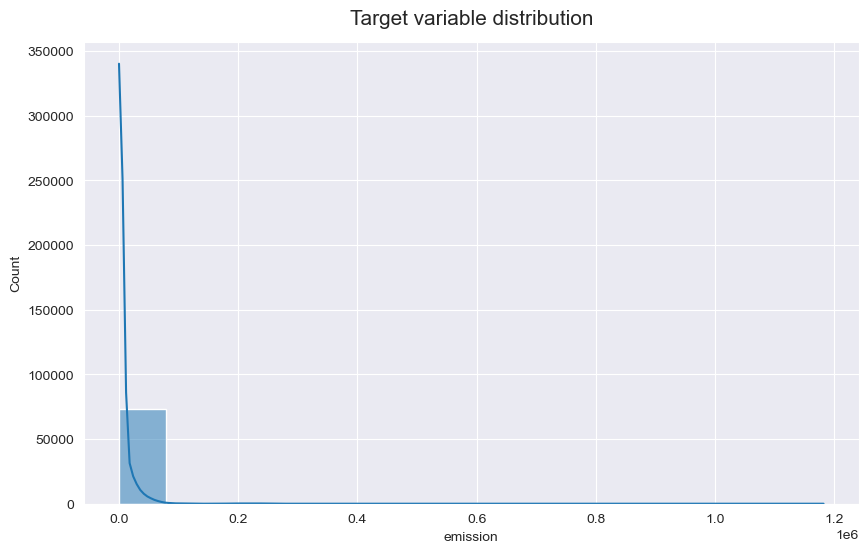

None

17.038027449698163

In [9]:
# Target variable distribution
sns.set_style('darkgrid')
plt.figure(figsize = (10, 6))
# kde argument adds a kernel density estimate line to the histogram
# bins argument specifies the number of bins or intervals for the histogram.
sns.histplot(train.emission, kde = True, bins = 15)
plt.title('Target variable distribution', y = 1.02, fontsize = 15)
display(plt.show(), train.emission.skew())


The target variable is skewed to the right with a a degree of ~17.

Some of the techniques used to handle skewness include:
- Log transform: Taking the logarithm of the target variable can help reduce right skewness. The log transformation is commonly used when the distribution of the data has a positive skew
- Box-cox transform: A more generalized approach to handle skewness. It can handle both positive and negative skewness and finds the optimal power transformation to make the data more normally distributed
- Square root transform: Taking the square root of the target variable can also be effective in reducing right skewness, especially when the data includes large values or outliers


The transformations above were applied individually and their impact was assessed on reducing the skewness of the target variable. The transformation that provided the best result in terms of reducing skewness and improving the distribution of the data was *Box-Cox Transform*

The techniques, with their skewness:
- Log transform: -0.2872766061413095
- Box-cox transform: 0.0063173466222045845
- Square root transform: 6.4783752800760555

The transformation that provided the best result in terms of reducing skewness and improving the distribution of the data was *Box-Cox Transform*

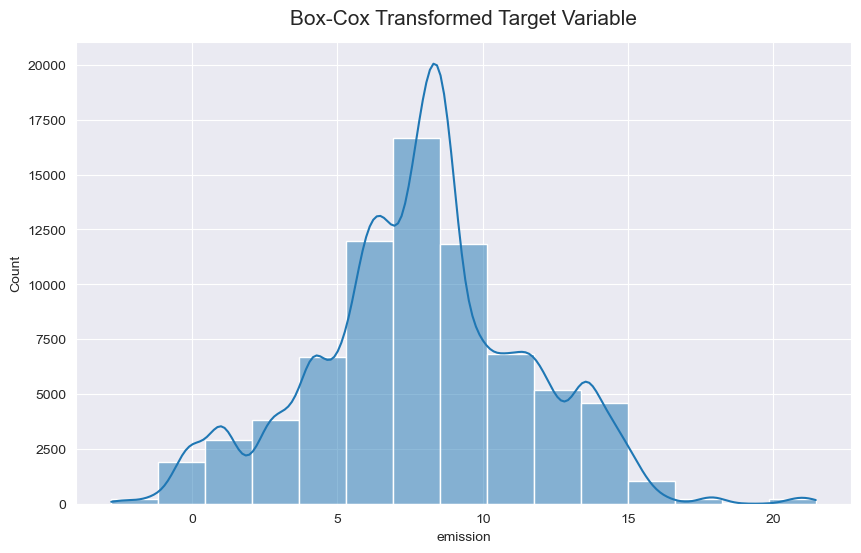

Skewness: 0.0063173466222045845


In [10]:
# `_` is used as a placeholder to ignore the lambda parameter
# boxcox() function will determine the lambda value automatically
# Box-Cox transform
train['emission'], _ = boxcox(train['emission'])

# Visualize the transformed data
plt.figure(figsize=(10, 6))
sns.histplot(train['emission'], kde=True, bins=15)
plt.title('Box-Cox Transformed Target Variable', y=1.02, fontsize=15)

# Calculate skewness of emission_boxcox
boxcox_skewness = train['emission'].skew()

# Display the plots and the skewness
plt.show()
print(f"Skewness: {boxcox_skewness}")

<a name="Outliers"></a>
## 4. Outliers


Outliers are those data points which differ significantly from other observations present in given dataset.


 

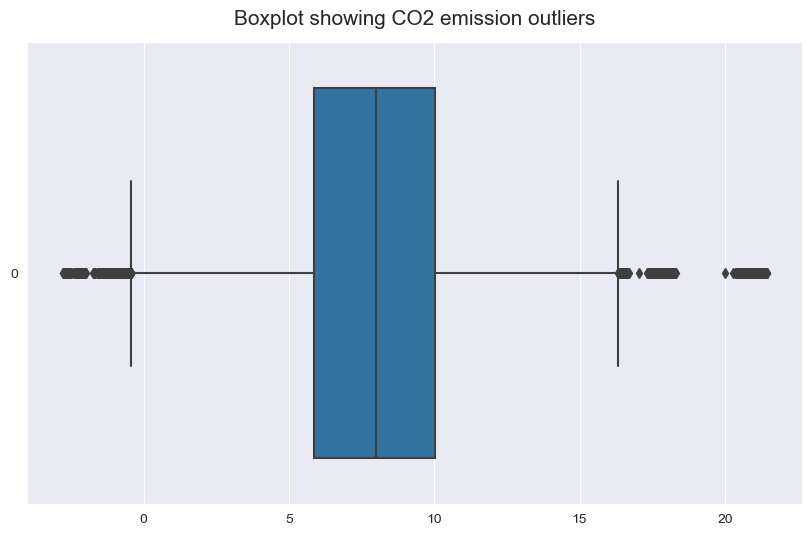

In [11]:
# Plot the boxplot of transformed data to show outliers
sns.set_style('darkgrid')
plt.figure(figsize = (10, 6))
sns.boxplot(train['emission'], orient='h')
plt.title('Boxplot showing CO2 emission outliers', y = 1.02, fontsize = 15)  
plt.show()

Techniques to handle outliers by:
 - Transforming the outliers by scaling - log transformation, box-cox transformation etc.
 - Dropping outliers
 - Imputation by replacing outliers with mean, median etc.

In [12]:
Q1 = train['emission'].quantile(0.25)
Q3 = train['emission'].quantile(0.75)

# Interquartile Range
IQR = Q3 - Q1
lower_quantile = Q1 - 1.5 * IQR
upper_quantile = Q3 + 1.5 * IQR

print(f"Lower Quantile: {lower_quantile}")
print(f"Upper Quantile: {upper_quantile}")


Lower Quantile: -0.4466643718293044
Upper Quantile: 16.334216909830467


In [13]:
# Find values outside the quantiles
values_outside_quantiles = (train['emission'] < lower_quantile) | (train['emission'] > upper_quantile)
print(train['emission'][values_outside_quantiles])

8405    -0.69069
8406    -0.60818
8407    -0.56200
8408    -0.54949
8409    -0.50722
8457    -0.68158
8458    -0.59304
8459    -0.57252
8460    -0.57644
8461    -0.55886
8509    -0.63230
8510    -0.61997
8511    -0.62307
8512    -0.59470
8561    -0.61149
8562    -0.57017
8563    -0.56132
8564    -0.52833
8609    -0.74251
20295   20.43638
20296   20.57765
20297   20.68871
20298   20.70218
20299   20.73529
20300   20.86735
20301   20.83306
20302   20.82985
20303   21.15667
20304   21.17382
20305   21.13209
20306   21.09549
20307   21.13801
20308   21.17822
20309   21.21774
20310   21.11160
20311   21.19355
20312   21.21887
20313   21.42929
20314   21.44552
20315   21.43116
20316   21.32678
20317   21.40180
20318   21.40304
20319   21.46013
20320   21.41113
20321   21.40878
20322   21.38045
20323   21.37042
20324   21.37676
20325   21.29291
20326   21.26455
20327   21.28194
20328   21.25427
20329   20.99858
20330   21.13864
20331   21.11292
20332   21.08791
20333   21.12870
20334   21.011

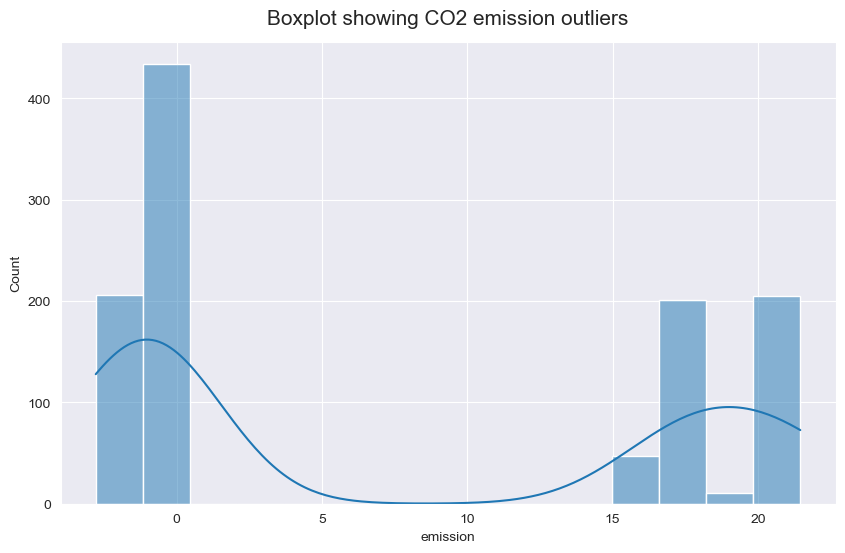

Count of values outside the quantiles: 1104


In [14]:
# Plot the boxplot of only the outliers 
sns.set_style('darkgrid')
plt.figure(figsize = (10, 6))
sns.histplot(train['emission'][values_outside_quantiles], kde=True, bins=15)
plt.title('Boxplot showing CO2 emission outliers', y = 1.02, fontsize = 15)  
plt.show()

# Calculate the count of values outside the quantiles
values_outside_quantiles2 = train[(train['emission'] < lower_quantile) | (train['emission'] > upper_quantile)]
outlier_count = len(values_outside_quantiles2)

# Display the count of values outside the quantiles
print("Count of values outside the quantiles:", outlier_count)

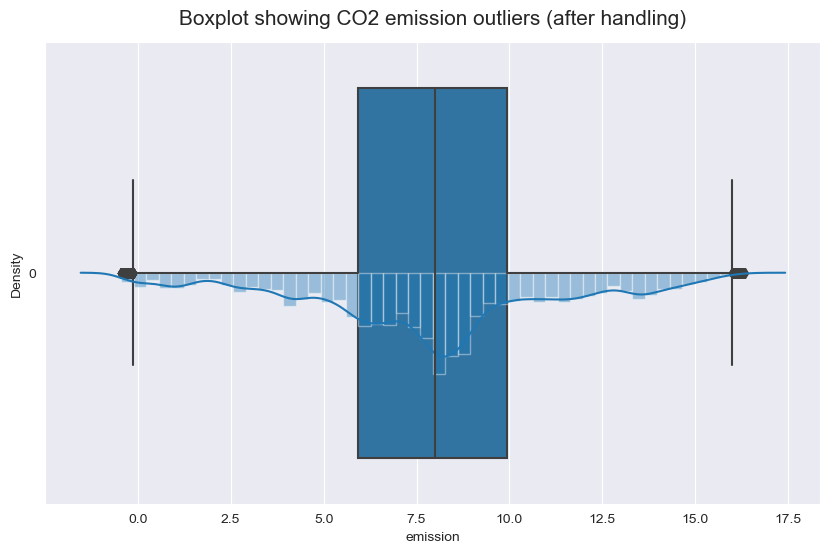

In [15]:
# Replace outliers with the median value
train['emission'][values_outside_quantiles] = np.median(train['emission'])

# Plot the boxplot after handling outliers
sns.set_style('darkgrid')
plt.figure(figsize=(10, 6))
sns.boxplot(train['emission'], orient='h')
sns.distplot(train['emission'])
plt.title('Boxplot showing CO2 emission outliers (after handling)', y=1.02, fontsize=15)
plt.show()

<a name="Geo"></a>
## 5. Geo Visualisation - EDA

In [16]:
# Combine train and test for easy visualisation
train_coords = train.drop_duplicates(subset = ['latitude', 'longitude'])
test_coords = test.drop_duplicates(subset = ['latitude', 'longitude'])
train_coords['set_type'], test_coords['set_type'] = 'train', 'test'

all_data = pd.concat([train_coords, test_coords], ignore_index = True)
# Create point geometries

geometry = gpd.points_from_xy(all_data.longitude, all_data.latitude)
geo_df = gpd.GeoDataFrame(
    all_data[["latitude", "longitude", "set_type"]], geometry=geometry
)

# Preview the geopandas df
geo_df.head()

latitude  longitude set_type                    geometry
0 -23.73000   28.77000    train  POINT (28.77000 -23.73000)
1 -23.73000   28.77000    train  POINT (28.77000 -23.73000)
2 -23.73000   28.87000    train  POINT (28.87000 -23.73000)
3 -23.73000   28.87000    train  POINT (28.87000 -23.73000)
4 -23.73000   28.97000    train  POINT (28.97000 -23.73000)

In [17]:
# Create a canvas to plot your map on
all_data_map = folium.Map(prefer_canvas=True)

# Create a geometry list from the GeoDataFrame
geo_df_list = [[point.xy[1][0], point.xy[0][0]] for point in geo_df.geometry]

# Iterate through list and add a marker for each volcano, color-coded by its type.
i = 0
for coordinates in geo_df_list:
    # assign a color marker for the type set
    if geo_df.set_type[i] == "train":
        type_color = "green"
    elif geo_df.set_type[i] == "test":
        type_color = "orange"

    # Place the markers 
    all_data_map.add_child(
        folium.CircleMarker(
            location=coordinates,
            radius = 1,
            weight = 4,
            zoom =10,
            popup= 
            "Set: " + str(geo_df.set_type[i]) + "<br>"
            "Coordinates: " + str([round(x, 2) for x in geo_df_list[i]]),
            color =  type_color),
        )
    i = i + 1
all_data_map.fit_bounds(all_data_map.get_bounds())
all_data_map

<a name="Missing"></a>
## 6. Missing values and duplicates

In [18]:
# Check for missing values
train.isnull().sum().any(), test.isnull().sum().any() 

(True, True)

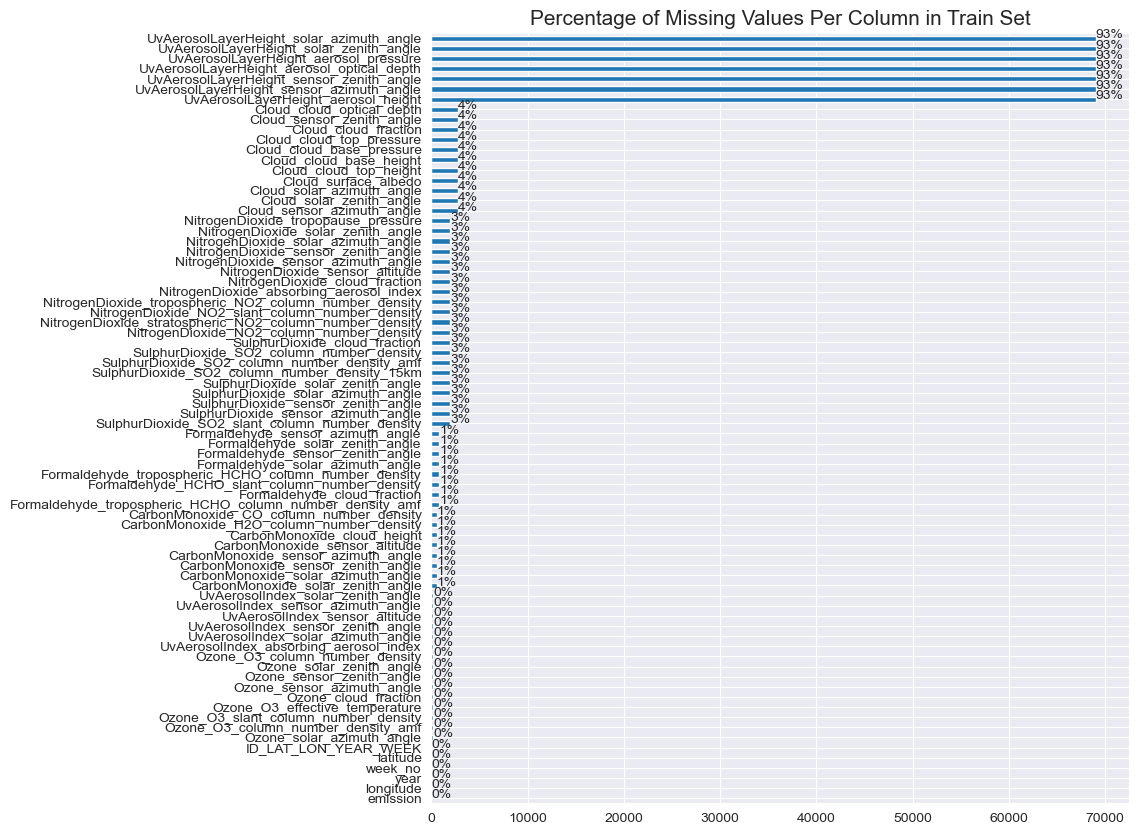

In [19]:
# Plot missing values in train set
ax = train.isna().sum().sort_values(ascending = False)[:76][::-1].plot(kind = 'barh', figsize = (9, 10))
plt.title('Percentage of Missing Values Per Column in Train Set', fontdict={'size':15})
for p in ax.patches:
    percentage ='{:,.0f}%'.format((p.get_width()/train.shape[0])*100)
    width, height =p.get_width(),p.get_height()
    x=p.get_x()+width+0.02
    y=p.get_y()+height/2
    ax.annotate(percentage,(x,y))

### Missing values

Techniques to handle missing values:
 - Fill in missing values with mode, mean, median..
 - Drop Missing datapoints with missing values
 - Fill in with a large number e.g -999999

In [20]:
# Drop the columns that have 93% empty values
columns_to_drop = [
    'UvAerosolLayerHeight_aerosol_height',
    'UvAerosolLayerHeight_sensor_azimuth_angle',
    'UvAerosolLayerHeight_sensor_zenith_angle',
    'UvAerosolLayerHeight_aerosol_optical_depth',
    'UvAerosolLayerHeight_aerosol_pressure',
    'UvAerosolLayerHeight_solar_zenith_angle',
    'UvAerosolLayerHeight_solar_azimuth_angle'
]

train.drop(columns_to_drop, axis=1, inplace=True)
test.drop(columns_to_drop, axis=1, inplace=True)

train.shape

(74005, 69)

In [21]:
# Fill missing values with the mean for multiple columns

columns_to_fill = list(train.columns)
for column in columns_to_fill[5:]:
   train[column].fillna(train[column].median(), inplace=True)


### Duplicate values

In [22]:
# Check for duplicates
train.duplicated().any(), test.duplicated().any()

(False, False)

<a name="Dates"></a>
## 7. Date features EDA

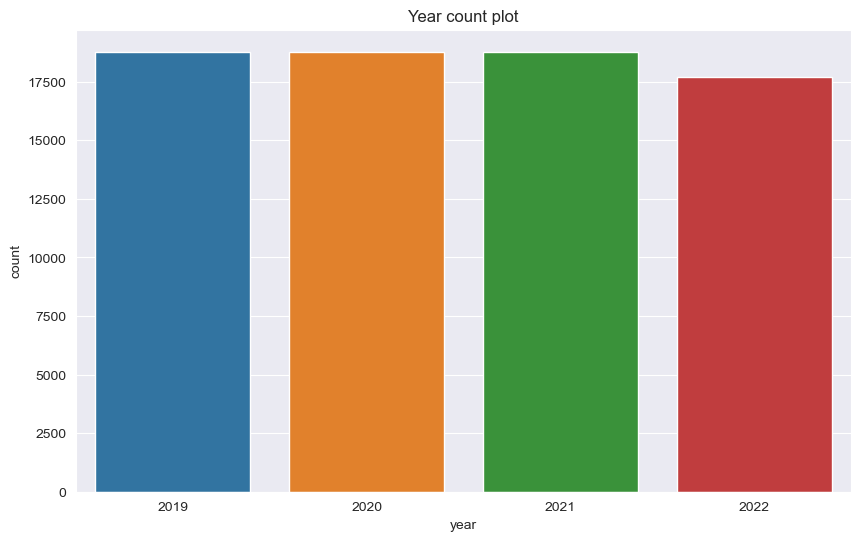

In [23]:
# Year countplot
plt.figure(figsize = (10, 6))
sns.countplot(x = 'year', data = train)
plt.title('Year count plot')
plt.show()

- The number of observations of CO2 emissions are relatively the same across the years
- Year 2022 has fewer number of observations

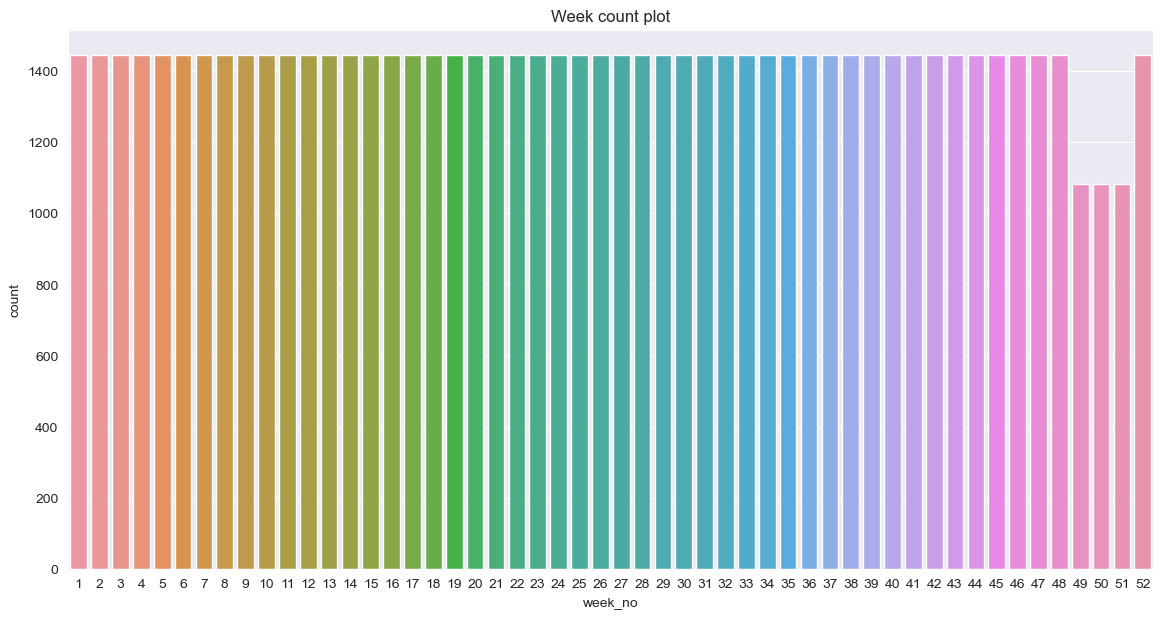

In [24]:
# Week countplot
plt.figure(figsize = (14, 7))
sns.countplot(x = 'week_no', data = train)
plt.title('Week count plot')
plt.show()

- The number of observations of CO2 emissions are relatively the same across the weeks
- Weeks 49, 50 and 51  have fewer number of observations when compared to the other weeks

In [25]:
# Let's see the number of weeks per year that had observations
train.drop_duplicates(subset = ['year', 'week_no']).groupby(['year'])[['week_no']].count()

week_no
year         
2019       52
2020       52
2021       52
2022       49

- The year 2022 has only 49 weeks available in the data

<a name="Correlations"></a>
## 8. Correlations - EDA

In [79]:
# Top 20 correlated features to the target
correlated_features = abs(train.corr()['emission']).sort_values(ascending = False).head(70)
correlated_features

emission                                                  1.00000
NitrogenDioxide_NO2_column_number_density                 0.28840
NitrogenDioxide_tropospheric_NO2_column_number_density    0.28416
NitrogenDioxide_NO2_slant_column_number_density           0.24445
SulphurDioxide_SO2_column_number_density_15km             0.07252
SulphurDioxide_SO2_slant_column_number_density            0.06635
SulphurDioxide_SO2_column_number_density                  0.06020
Cloud_surface_albedo                                      0.05896
UvAerosolLayerHeight_sensor_azimuth_angle                 0.05497
longitude                                                 0.05394
UvAerosolIndex_sensor_altitude                            0.04477
UvAerosolLayerHeight_solar_azimuth_angle                  0.04376
latitude                                                  0.04372
NitrogenDioxide_sensor_altitude                           0.04069
UvAerosolLayerHeight_aerosol_optical_depth                0.04021
CarbonMono

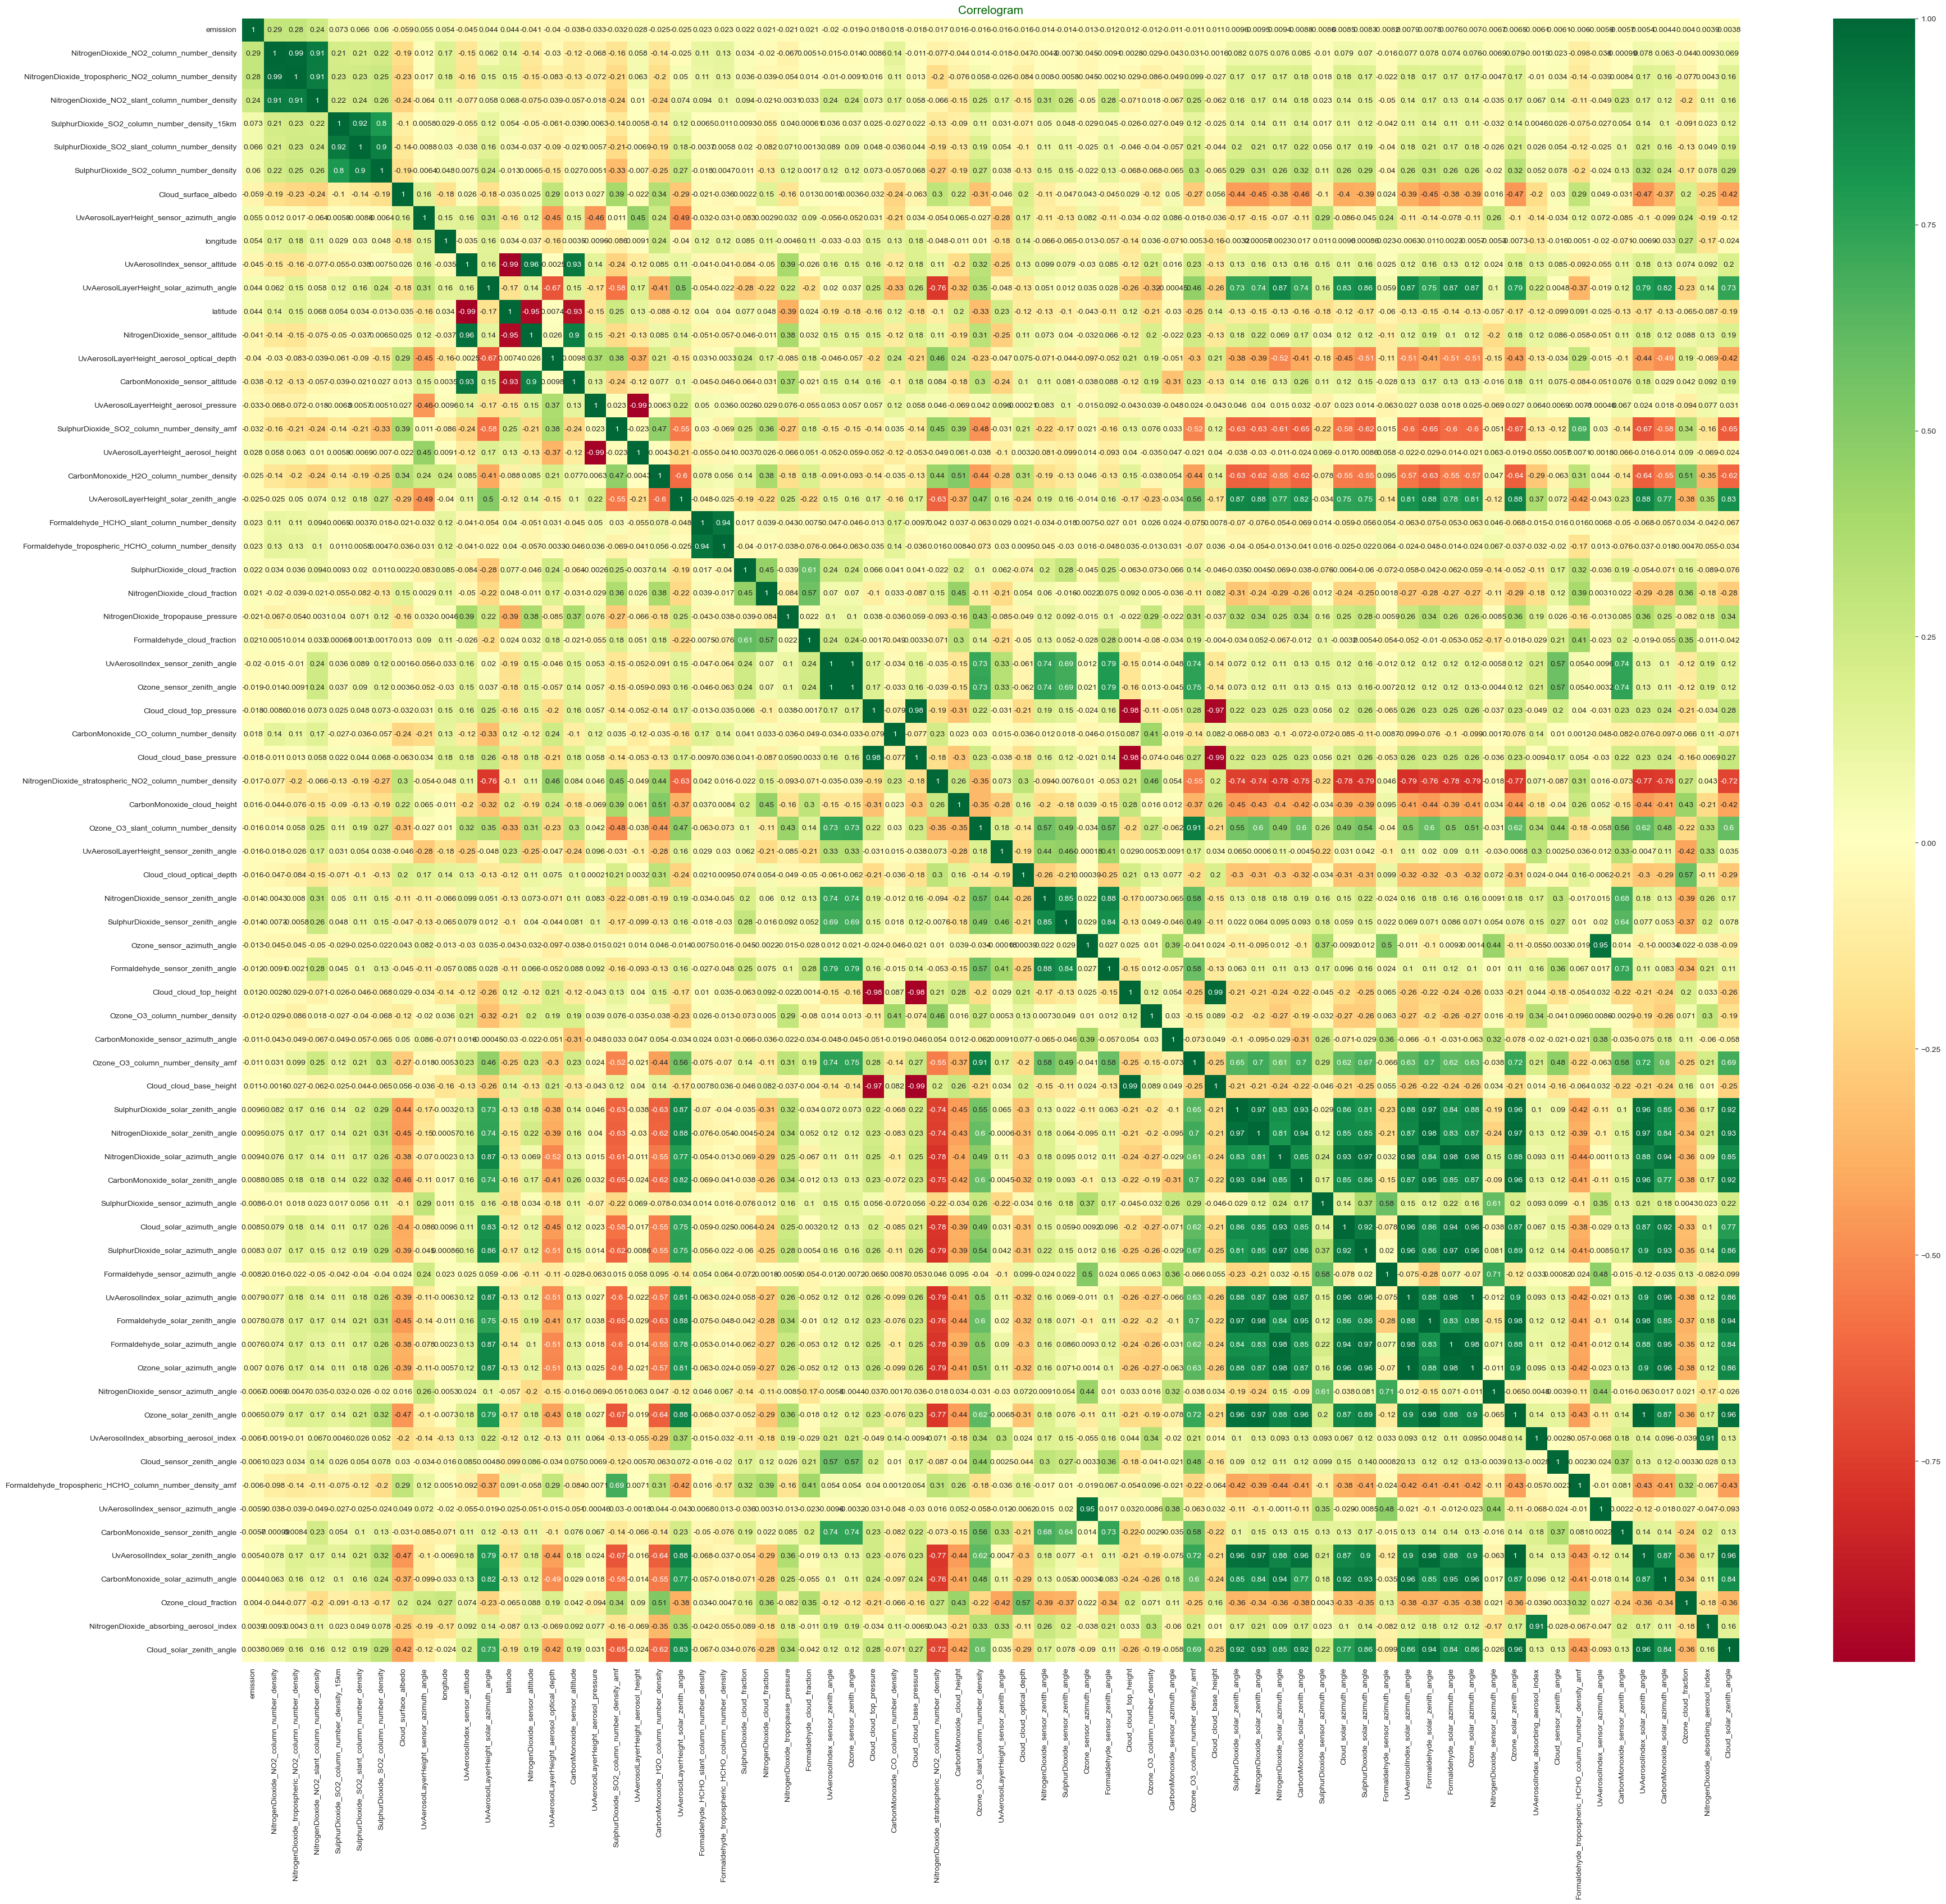

In [58]:
# Quantify correlations between features
corr = train[list(correlated_features.index)].corr()
plt.figure(figsize = (43, 38))
sns.heatmap(corr, cmap='RdYlGn', annot = True, center = 0)
plt.title('Correlogram', fontsize = 15, color = 'darkgreen')
plt.show()

<a name="Timeseries"></a>
## 9. Timeseries visualization - EDA

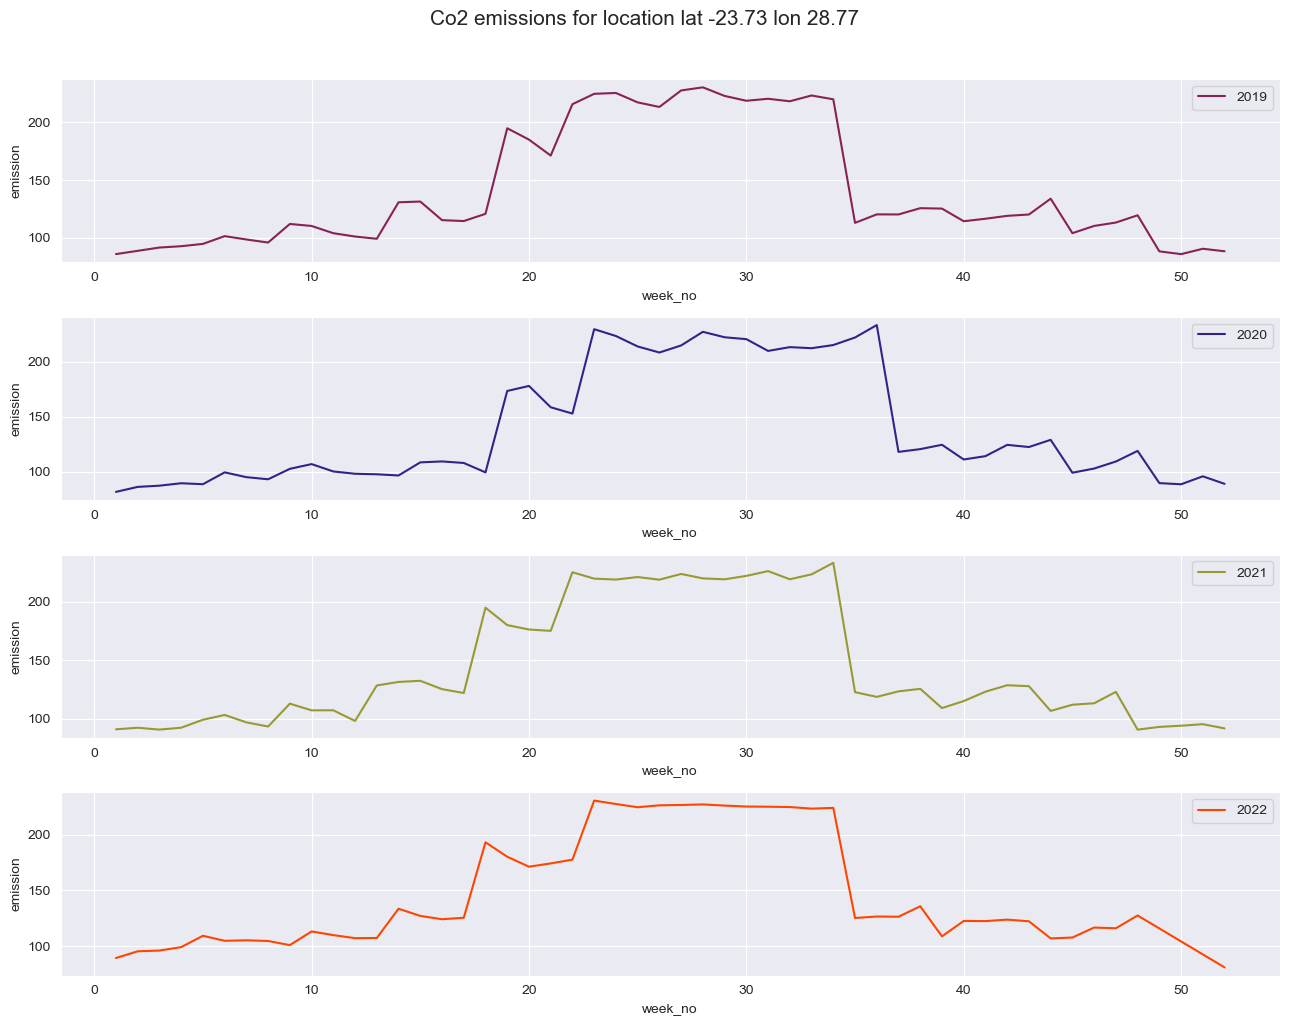

In [60]:
# Sample a unique location and visualize its emissions across the years
train.latitude, train.longitude = round(train.latitude, 2), round(train.longitude, 2)
sample_loc = train[(train.latitude == -23.73) & (train.longitude == 28.77)]

# Plot a line plot
sns.set_style('darkgrid')
fig, axes = plt.subplots(nrows = 4, ncols = 1, figsize = (13, 10))
fig.suptitle('Co2 emissions for location lat -23.73 lon 28.77', y=1.02, fontsize = 15)

for ax, data, year, color, in zip(axes.flatten(), sample_loc, sample_loc.year.unique(), ['#882255','#332288', '#999933' , 'orangered']):
  df = sample_loc[sample_loc.year == year]
  sns.lineplot(x=df.week_no,y= df.emission, ax = ax, label = year, color = color)
plt.legend()
plt.tight_layout()

<a name="Engineering"></a>
## 10. Feature engineering


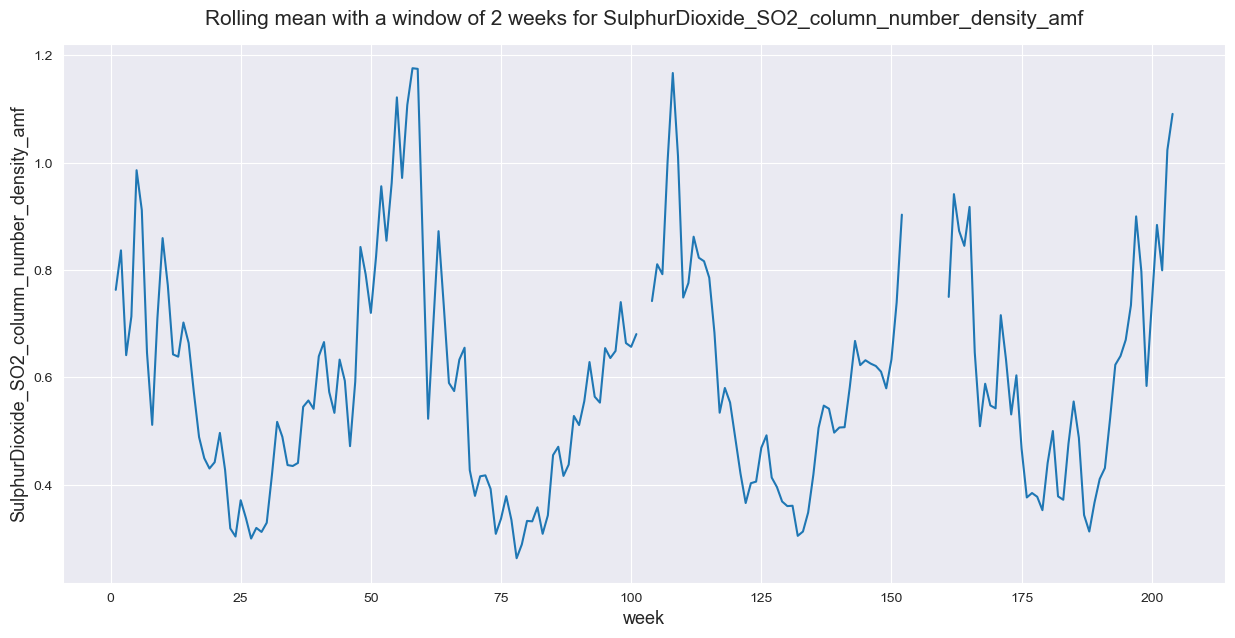

In [61]:
# Examples of feature engineering - Aggregations, cumulative differences, moving averages ...
# Lets explore the rolling mean
# First we create a unique location from lat lon
train['location'] = [str(x) + '_' + str(y) for x, y in zip(train.latitude, train.longitude)]
test['location'] = [str(x) + '_' + str(y) for x, y in zip(test.latitude, test.longitude)]

# Filter based on one location
example_location = train[train.location == '-23.73_28.77']

# Calculate rolling mean for SulphurDioxide_SO2_column_number_density_amf with a window of 2 weeks
rolling_mean = example_location['SulphurDioxide_SO2_column_number_density_amf'].rolling(window = 2).mean()

# Visualise rolling mean
plt.figure(figsize = (15, 7))
rolling_mean.plot()
plt.title('Rolling mean with a window of 2 weeks for SulphurDioxide_SO2_column_number_density_amf', y = 1.02, fontsize = 15)
plt.xlabel('week', y = 1.05, fontsize = 13)
plt.ylabel('SulphurDioxide_SO2_column_number_density_amf', x = 1.05, fontsize = 13)
plt.show()

 - There is a cyclic pattern from the above graph, which clearly shows that there is a pattern - This will be helpful to our model
 - With more research and domain knowledge generate useful features that can improve your model performance

 Other examples of feature engineering:
  - Creating cluster regions
  - Interactions between different pollutants - ratios, additions,subtractions...
  - Time series features

In [62]:
import pandas as pd
import numpy as np

# Function to calculate rolling mean for each column
def calculate_rolling_mean(data, window):
    return data.rolling(window=window, min_periods=1).mean()

# Function to calculate rolling median for each column
def calculate_rolling_median(data, window):
    return data.rolling(window=window, min_periods=1).median()

# Function to calculate weighted moving average for each column
def calculate_weighted_moving_average(data, window):
    weights = np.arange(1, window + 1)
    return data.rolling(window=window, min_periods=1).apply(lambda x: np.dot(x, weights[:len(x)]) / np.sum(weights[:len(x)]), raw=True)

# Function to calculate exponentially weighted moving average for each column
def calculate_exponential_moving_average(data, alpha):
    return data.ewm(alpha=alpha, adjust=False).mean()

# Define the window sizes for moving averages
window_sizes = [2, 3, 4]  # Add or modify window sizes as desired

# Convert columns to numeric values
# train_numeric = train.iloc[:, 5:].apply(pd.to_numeric, errors='coerce')
# test_numeric = test.iloc[:, 5:].apply(pd.to_numeric, errors='coerce')

train_numeric = train.iloc[:, -3:-66:-1].apply(pd.to_numeric, errors='coerce')
test_numeric = test.iloc[:, -2:-65:-1].apply(pd.to_numeric, errors='coerce')

# Feature engineering train
train_roll_features = train.sort_values(by=['location', 'year', 'week_no'])
for column in train_numeric.columns:
    train_roll_features[column + '_roll_mean'] = calculate_rolling_mean(train_numeric[column], window=2)
    train_roll_features[column + '_roll_median'] = calculate_rolling_median(train_numeric[column], window=3)
    train_roll_features[column + '_weighted_ma'] = calculate_weighted_moving_average(train_numeric[column], window=4)
#     train_roll_features[column + '_ewma'] = calculate_exponential_moving_average(train_numeric[column], alpha=0.5)
    
# Feature engineering test
test_roll_features = test.sort_values(by=['location', 'year', 'week_no'])
for column in test_numeric.columns:
    test_roll_features[column + '_roll_mean'] = calculate_rolling_mean(test_numeric[column], window=2)
    test_roll_features[column + '_roll_median'] = calculate_rolling_median(test_numeric[column], window=3)
    test_roll_features[column + '_weighted_ma'] = calculate_weighted_moving_average(test_numeric[column], window=4)
#     test_roll_features[column + '_ewma'] = calculate_exponential_moving_average(test_numeric[column], alpha=0.5)


In [63]:
print(test_roll_features.columns)

Index(['ID_LAT_LON_YEAR_WEEK', 'latitude', 'longitude', 'year', 'week_no',
       'SulphurDioxide_SO2_column_number_density',
       'SulphurDioxide_SO2_column_number_density_amf',
       'SulphurDioxide_SO2_slant_column_number_density',
       'SulphurDioxide_cloud_fraction', 'SulphurDioxide_sensor_zenith_angle',
       ...
       'year_weighted_ma', 'longitude_roll_mean', 'longitude_roll_median',
       'longitude_weighted_ma', 'latitude_roll_mean', 'latitude_roll_median',
       'latitude_weighted_ma', 'ID_LAT_LON_YEAR_WEEK_roll_mean',
       'ID_LAT_LON_YEAR_WEEK_roll_median', 'ID_LAT_LON_YEAR_WEEK_weighted_ma'],
      dtype='object', length=205)


In [64]:
# test_numeric.columns

In [65]:
# Merge engineered features with train and test set

#Train
train_eng = train.sort_values(by = ['location', 'year', 'week_no'], ignore_index = True).merge(train_roll_features)

# Test
test_eng = test.sort_values(by = ['location', 'year', 'week_no'], ignore_index = True).merge(test_roll_features)


# Preview engineered test set
train_eng.head()


ID_LAT_LON_YEAR_WEEK  latitude  longitude  year  week_no  \
0  ID_-23.73_28.77_2019_1 -23.73000   28.77000  2019        1   
1  ID_-23.73_28.77_2019_2 -23.73000   28.77000  2019        2   
2  ID_-23.73_28.77_2019_3 -23.73000   28.77000  2019        3   
3  ID_-23.73_28.77_2019_4 -23.73000   28.77000  2019        4   
4  ID_-23.73_28.77_2019_5 -23.73000   28.77000  2019        5   

   SulphurDioxide_SO2_column_number_density  \
0                                   0.00017   
1                                  -0.00016   
2                                  -0.00007   
3                                   0.00015   
4                                   0.00002   

   SulphurDioxide_SO2_column_number_density_amf  \
0                                       0.71317   
1                                       0.81291   
2                                       0.86031   
3                                       0.42228   
4                                       1.00458   

   SulphurDioxide_SO2_slant_column_number_density  \
0                                         0.00010   
1                                        -0.00014   
2                                        -0.00006   
3                                         0.00009   
4                                         0.00003   

   SulphurDioxide_cloud_fraction  SulphurDioxide_sensor_zenith_angle  ...  \
0                        0.22393                            56.89620  ...   
1                        0.08028                            31.13726  ...   
2                        0.16105                            44.44106  ...   
3                        0.04650                            61.25250  ...   
4                        0.21425                            30.80077  ...   

   year_weighted_ma  longitude_roll_mean  longitude_roll_median  \
0        2019.00000             28.77000               28.77000   
1        2019.00000             28.77000               28.77000   
2        2019.00000             28.77000               28.77000   
3        2019.00000             28.77000               28.77000   
4        2019.00000             28.77000               28.77000   

   longitude_weighted_ma  latitude_roll_mean  latitude_roll_median  \
0               28.77000           -23.73000             -23.73000   
1               28.77000           -23.73000             -23.73000   
2               28.77000           -23.73000             -23.73000   
3               28.77000           -23.73000             -23.73000   
4               28.77000           -23.73000             -23.73000   

   latitude_weighted_ma  ID_LAT_LON_YEAR_WEEK_roll_mean  \
0             -23.73000                             NaN   
1             -23.73000                             NaN   
2             -23.73000                             NaN   
3             -23.73000                             NaN   
4             -23.73000                             NaN   

   ID_LAT_LON_YEAR_WEEK_roll_median  ID_LAT_LON_YEAR_WEEK_weighted_ma  
0                               NaN                               NaN  
1                               NaN                               NaN  
2                               NaN                               NaN  
3                               NaN                               NaN  
4                               NaN                               NaN  

[5 rows x 206 columns]

In [66]:
test_eng.head()

ID_LAT_LON_YEAR_WEEK  latitude  longitude  year  week_no  \
0   ID_-23.53_27.47_2019_1 -23.53000   27.47000  2019        1   
1   ID_-23.53_27.47_2019_5 -23.53000   27.47000  2019        5   
2   ID_-23.53_27.47_2019_9 -23.53000   27.47000  2019        9   
3  ID_-23.53_27.47_2019_18 -23.53000   27.47000  2019       18   
4  ID_-23.53_27.47_2019_22 -23.53000   27.47000  2019       22   

   SulphurDioxide_SO2_column_number_density  \
0                                   0.00008   
1                                   0.00019   
2                                   0.00024   
3                                   0.00118   
4                                   0.00189   

   SulphurDioxide_SO2_column_number_density_amf  \
0                                       0.45447   
1                                       0.78304   
2                                       0.48104   
3                                       0.36035   
4                                       0.38902   

   SulphurDioxide_SO2_slant_column_number_density  \
0                                         0.00003   
1                                         0.00014   
2                                         0.00011   
3                                         0.00041   
4                                         0.00073   

   SulphurDioxide_cloud_fraction  SulphurDioxide_sensor_zenith_angle  ...  \
0                        0.11429                            55.54896  ...   
1                        0.16114                            38.09723  ...   
2                        0.12161                            59.71799  ...   
3                        0.17076                            63.24972  ...   
4                        0.10735                            27.92114  ...   

   year_weighted_ma  longitude_roll_mean  longitude_roll_median  \
0        2019.00000             27.47000               27.47000   
1        2019.00000             27.47000               27.47000   
2        2019.00000             27.47000               27.47000   
3        2019.00000             27.47000               27.47000   
4        2019.00000             27.47000               27.47000   

   longitude_weighted_ma  latitude_roll_mean  latitude_roll_median  \
0               27.47000           -23.53000             -23.53000   
1               27.47000           -23.53000             -23.53000   
2               27.47000           -23.53000             -23.53000   
3               27.47000           -23.53000             -23.53000   
4               27.47000           -23.53000             -23.53000   

   latitude_weighted_ma  ID_LAT_LON_YEAR_WEEK_roll_mean  \
0             -23.53000                             NaN   
1             -23.53000                             NaN   
2             -23.53000                             NaN   
3             -23.53000                             NaN   
4             -23.53000                             NaN   

   ID_LAT_LON_YEAR_WEEK_roll_median  ID_LAT_LON_YEAR_WEEK_weighted_ma  
0                               NaN                               NaN  
1                               NaN                               NaN  
2                               NaN                               NaN  
3                               NaN                               NaN  
4                               NaN                               NaN  

[5 rows x 205 columns]

> **Note** </br>
*train_eng = train.sort_values(by = ['location', 'year', 'week_no'], ignore_index = True).merge(train_roll_mean, how = 'left', left_index=True, right_index=True)* </br>
*test_eng = test.sort_values(by = ['location', 'year', 'week_no'], ignore_index = True).merge(test_roll_mean, how = 'left', left_index=True, right_index=True)* </br></br>
The code above would have produced columns with "_x" and "_y" suffixes in the train_eng and test_eng dataframes </br>
This is due to the merge operation performed. When two dataframes are merged, and they have overlapping column names, pandas automatically adds suffixes to the column names to differentiate them </br></br>
When merging two DataFrames that have overlapping column names, pandas adds the suffix "_x" to the column names from the left dataframe eg. (train_eng) and "_y" to the column names from the right dataframe eg. (train_roll_features) to avoid naming conflicts </br> 
This suffixing allows you to distinguish between the columns from the original DataFrame and the merged DataFrame </br>

<a name="Modelling"></a>
## 11.  Modelling

In [67]:
# Selecting the independent variables and the target variable

X = train_eng.drop(['ID_LAT_LON_YEAR_WEEK', 'location', 'emission'], axis = 1).fillna(0)
y = train_eng.emission

# Splitting the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3, random_state = SEED)

# Instantiating the model
clf = RandomForestRegressor(random_state = SEED, n_jobs=-1)
clf.fit(X_train, y_train)

# Making predictions
y_pred = clf.predict(X_test)

# Measuring the accuracy of the model
print(f'RMSE Score: {mean_squared_error(y_test, y_pred, squared=False)}')

RMSE Score: 15854.23004701769


### Checking to see how our scores are doing

> Score 1: 0.4881085195171974 </br>
> Score 2: 0.11341201478025692 </br>
> Score 3: 0.4333985364702388 </br>
> Score 4: 0.43947240996261056

In [68]:
X_test.head()

latitude  longitude  year  week_no  \
36836 -28.13000   21.17000  2021       38   
54382 -29.63000   30.57000  2020        6   
59155 -29.83000   30.87000  2021       12   
49683 -29.43000   30.27000  2020       22   
37156 -28.13000   21.37000  2019       52   

       SulphurDioxide_SO2_column_number_density  \
36836                                   0.00036   
54382                                   0.00026   
59155                                   0.00000   
49683                                  -0.00037   
37156                                  -0.00005   

       SulphurDioxide_SO2_column_number_density_amf  \
36836                                       0.40022   
54382                                       0.70984   
59155                                       0.00000   
49683                                       0.20361   
37156                                       1.06684   

       SulphurDioxide_SO2_slant_column_number_density  \
36836                                         0.00011   
54382                                         0.00018   
59155                                         0.00000   
49683                                        -0.00006   
37156                                        -0.00004   

       SulphurDioxide_cloud_fraction  SulphurDioxide_sensor_zenith_angle  \
36836                        0.12798                            59.82414   
54382                        0.05779                            60.64862   
59155                        0.00000                             0.00000   
49683                        0.19163                            61.25743   
37156                        0.12360                            31.04180   

       SulphurDioxide_SO2_column_number_density_15km  ...  year_weighted_ma  \
36836                                        0.00004  ...        2021.00000   
54382                                        0.00007  ...        2020.00000   
59155                                        0.00000  ...        2021.00000   
49683                                       -0.00002  ...        2020.00000   
37156                                       -0.00002  ...        2019.00000   

       longitude_roll_mean  longitude_roll_median  longitude_weighted_ma  \
36836             21.17000               21.17000               21.17000   
54382             30.57000               30.57000               30.57000   
59155             30.87000               30.87000               30.87000   
49683             30.27000               30.27000               30.27000   
37156             21.37000               21.37000               21.37000   

       latitude_roll_mean  latitude_roll_median  latitude_weighted_ma  \
36836           -28.13000             -28.13000             -28.13000   
54382           -29.63000             -29.63000             -29.63000   
59155           -29.83000             -29.83000             -29.83000   
49683           -29.43000             -29.43000             -29.43000   
37156           -28.13000             -28.13000             -28.13000   

       ID_LAT_LON_YEAR_WEEK_roll_mean  ID_LAT_LON_YEAR_WEEK_roll_median  \
36836                         0.00000                           0.00000   
54382                         0.00000                           0.00000   
59155                         0.00000                           0.00000   
49683                         0.00000                           0.00000   
37156                         0.00000                           0.00000   

       ID_LAT_LON_YEAR_WEEK_weighted_ma  
36836                           0.00000  
54382                           0.00000  
59155                           0.00000  
49683                           0.00000  
37156                           0.00000  

[5 rows x 203 columns]

In [69]:
# Analyse predictions
pred_errors = X_test.copy()
pred_errors['emission'] = y_test
pred_errors['prediction'] = y_pred
pred_errors['error'] = abs(pred_errors.prediction - pred_errors.emission)
pred_errors = pred_errors[['latitude', 'longitude', 'year', 'week_no', 'emission', 'prediction', 'error']]
pred_errors.sort_values(by = 'error', ascending = False, inplace = True)
pred_errors.head()

latitude  longitude  year  week_no     emission   prediction  \
20432 -25.93000   29.37000  2021       34 992748.75000   6803.12445   
20397 -25.93000   29.37000  2020       51 934806.80000  31806.97517   
20396 -25.93000   29.37000  2020       50 914555.75000 140099.02867   
20295 -25.93000   29.37000  2019        1 742538.50000    376.73619   
20463 -25.93000   29.37000  2022       13 953849.75000 276933.41728   

             error  
20432 985945.62555  
20397 902999.82483  
20396 774456.72133  
20295 742161.76381  
20463 676916.33272

In [75]:
pred_errors.tail(20)

latitude  longitude  year  week_no  emission  prediction   error
29237 -26.93000   24.57000  2021       24   0.11146     0.10953 0.00193
43799 -28.63000   21.27000  2021       31   0.39836     0.39657 0.00179
39057 -28.23000   21.37000  2021        4   0.59372     0.59204 0.00168
43098 -28.53000   21.47000  2019       49  10.77325    10.77165 0.00160
39003 -28.23000   21.37000  2020        2   0.54977     0.54820 0.00157
37331 -28.13000   21.47000  2019       22   1.06154     1.06310 0.00156
35161 -28.03000   21.27000  2021        3   0.59807     0.59660 0.00147
45730 -29.03000   26.37000  2019       16 220.70720   220.70578 0.00142
37714 -28.13000   26.67000  2022       44  16.95744    16.95881 0.00137
37336 -28.13000   21.47000  2019       27   0.68413     0.68526 0.00114
39345 -28.23000   21.47000  2022       35   2.94847     2.94960 0.00113
32702 -27.23000   24.47000  2021        4   0.52517     0.52617 0.00100
35652 -28.03000   21.47000  2022       32   1.15194     1.15281 0.00087
37205 -28.13000   21.37000  2020       49   1.05596     1.05540 0.00056
43722 -28.63000   21.27000  2020        6   0.30905     0.30849 0.00055
36984 -28.13000   21.27000  2020       33   0.91673     0.91636 0.00037
35452 -28.03000   21.37000  2022       37   2.90080     2.90112 0.00033
35622 -28.03000   21.47000  2022        2   0.61495     0.61524 0.00029
38970 -28.23000   21.37000  2019       21   2.27552     2.27579 0.00026
8474  -24.13000   28.87000  2020       18   1.27807     1.27823 0.00016

In [71]:
train.emission.describe()

count     74005.00000
mean       7891.06097
std       52571.60466
min           0.04806
25%         154.54720
50%         723.13586
75%        2773.02930
max     1181701.20000
Name: emission, dtype: float64

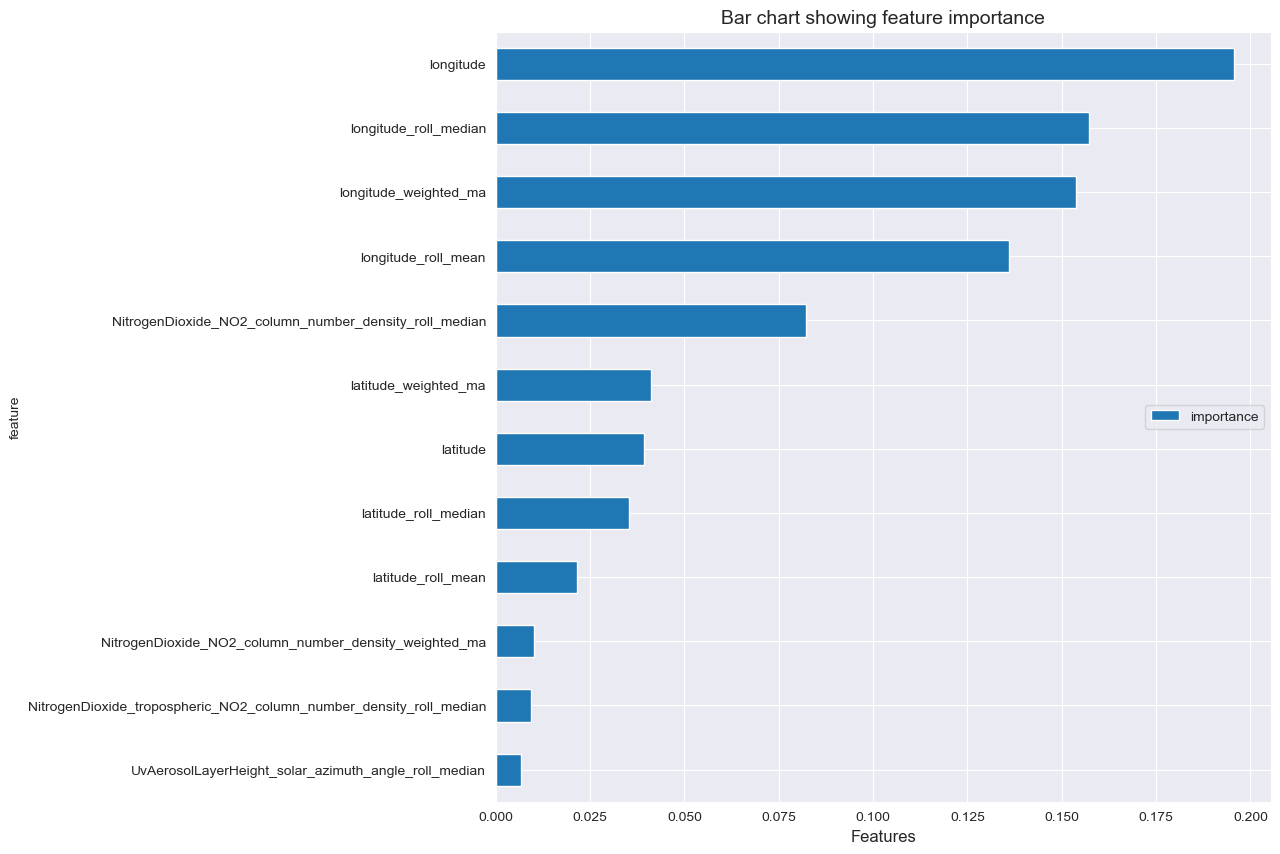

In [72]:
# Feature importance
impo_df = pd.DataFrame({'feature': X.columns, 'importance': clf.feature_importances_}).set_index('feature').sort_values(by = 'importance', ascending = False)
impo_df = impo_df[:12].sort_values(by = 'importance', ascending = True)
impo_df.plot(kind = 'barh', figsize = (10, 10))
plt.legend(loc = 'center right')
plt.title('Bar chart showing feature importance', fontsize = 14)
plt.xlabel('Features', fontsize = 12)
plt.show()

<a name="Predictions"></a>
## 12. Making predictions of the test set and creating a submission file

In [73]:
# Make prediction on the test set
test_df = test_eng.drop(['ID_LAT_LON_YEAR_WEEK', 'location'], axis = 1).fillna(0)
predictions = clf.predict(test_df)

# # Create a submission file
sub_file = pd.DataFrame({'ID_LAT_LON_YEAR_WEEK': test_eng.ID_LAT_LON_YEAR_WEEK, 'emission': predictions})
sub_file.head()

ID_LAT_LON_YEAR_WEEK    emission
0   ID_-23.53_27.47_2019_1  9765.09114
1   ID_-23.53_27.47_2019_5  3326.46640
2   ID_-23.53_27.47_2019_9  2702.14066
3  ID_-23.53_27.47_2019_18 23477.13968
4  ID_-23.53_27.47_2019_22 22308.74891

In [74]:
# Create file
sub_file.to_csv('BaselineSubmission2.csv', index = False)